In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import random
random.seed(13847942484)
import survivalstan
import numpy as np
import pandas as pd
from stancache import stancache
from matplotlib import pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/jacquelineburos/miniconda3/envs/python3/lib/python3.5/site-packages/Cython/Distutils/old_build_ext.py:30: UserWarning: Cython.Distutils.old_build_ext does not properly handle dependencies and is deprecated.
  "Cython.Distutils.old_build_ext does not properly handle dependencies "
/home/jacquelineburos/.local/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
INFO:stancache.seed:Setting seed to 1245502385


In [2]:
print(survivalstan.models.pem_survival_model_timevarying)

/*  Variable naming:
 // dimensions
 N          = total number of observations (length of data)
 S          = number of sample ids
 T          = max timepoint (number of timepoint ids)
 M          = number of covariates
 
 // data
 s          = sample id for each obs
 t          = timepoint id for each obs
 event      = integer indicating if there was an event at time t for sample s
 x          = matrix of real-valued covariates at time t for sample n [N, X]
 obs_t      = observed end time for interval for timepoint for that obs
 
*/
// Jacqueline Buros Novik <jackinovik@gmail.com>

functions {
  matrix spline(vector x, int N, int H, vector xi, int P) {
    matrix[N, H + P] b_x;         // expanded predictors
    for (n in 1:N) {
        for (p in 1:P) {
            b_x[n,p] <- pow(x[n],p-1);  // x[n]^(p-1)
        }
        for (h in 1:H)
          b_x[n, h + P] <- fmax(0, pow(x[n] - xi[h],P-1)); 
    }
    return b_x;
  }
}
data {
  // dimensions
  int<lower=1> N;
  int<lower=1> S;
 

In [3]:
d = stancache.cached(
    survivalstan.sim.sim_data_exp_correlated,
    N=100,
    censor_time=20,
    rate_form='1 + sex',
    rate_coefs=[-3, 0.5],
)
d['age_centered'] = d['age'] - d['age'].mean()
d.head()

INFO:stancache.stancache:sim_data_exp_correlated: cache_filename set to sim_data_exp_correlated.cached.N_100.censor_time_20.rate_coefs_54462717316.rate_form_1 + sex.pkl
INFO:stancache.stancache:sim_data_exp_correlated: Loading result from cache


,age,sex,rate,true_t,t,event,index,age_centered
0,59,male,0.082085,20.948771,20.000000,False,0,4.18
1,58,male,0.082085,12.827519,12.827519,True,1,3.18
2,61,female,0.049787,27.018886,20.000000,False,2,6.18
3,57,female,0.049787,62.220296,20.000000,False,3,2.18
4,55,male,0.082085,10.462045,10.462045,True,4,0.18


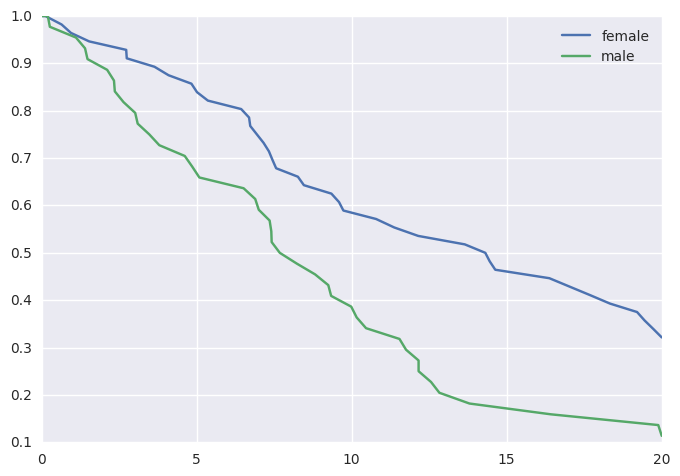

In [4]:
survivalstan.utils.plot_observed_survival(df=d[d['sex']=='female'], event_col='event', time_col='t', label='female')
survivalstan.utils.plot_observed_survival(df=d[d['sex']=='male'], event_col='event', time_col='t', label='male')
plt.legend()

In [5]:
dlong = stancache.cached(
    survivalstan.prep_data_long_surv,
    df=d, event_col='event', time_col='t'
)
dlong.sort_values(['index', 'end_time'], inplace=True)

INFO:stancache.stancache:prep_data_long_surv: cache_filename set to prep_data_long_surv.cached.df_33772694934.event_col_event.time_col_t.pkl
INFO:stancache.stancache:prep_data_long_surv: Loading result from cache


In [6]:
dlong.head()

,age,sex,rate,true_t,t,event,index,age_centered,key,end_time,end_failure
62,59,male,0.082085,20.948771,20.0,False,0,4.18,1,0.118611,False
3,59,male,0.082085,20.948771,20.0,False,0,4.18,1,0.196923,False
61,59,male,0.082085,20.948771,20.0,False,0,4.18,1,0.262114,False
71,59,male,0.082085,20.948771,20.0,False,0,4.18,1,0.641174,False
26,59,male,0.082085,20.948771,20.0,False,0,4.18,1,0.944220,False


In [7]:
testfit = survivalstan.fit_stan_survival_model(
    model_cohort = 'test model',
    model_code = survivalstan.models.pem_survival_model_timevarying,
    df = dlong,
    sample_col = 'index',
    timepoint_end_col = 'end_time',
    event_col = 'end_failure',
    formula = '~ age_centered + sex',
    iter = 10000,
    chains = 4,
    seed = 9001,
    FIT_FUN = stancache.cached_stan_fit,
    )

INFO:stancache.stancache:Step 1: Get compiled model code, possibly from cache
INFO:stancache.stancache:StanModel: cache_filename set to anon_model.cython_0_25_1.model_code_9304163442804524267.pystan_2_12_0_0.stanmodel.pkl
INFO:stancache.stancache:StanModel: Loading result from cache
INFO:stancache.stancache:Step 2: Get posterior draws from model, possibly from cache
INFO:stancache.stancache:sampling: cache_filename set to anon_model.cython_0_25_1.model_code_9304163442804524267.pystan_2_12_0_0.stanfit.chains_4.data_75232070308.iter_10000.seed_9001.pkl
INFO:stancache.stancache:sampling: Loading result from cache
/home/jacquelineburos/miniconda3/envs/python3/lib/python3.5/site-packages/stanity/psis.py:228: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif sort == 'in-place':
/home/jacquelineburos/miniconda3/envs/python3/lib/python3.5/site-packages/stanity/psis.py:246: VisibleDeprecationWarning: using a non-

## superficial check of convergence

In [23]:
survivalstan.utils.print_stan_summary([testfit], pars='lp__')

            mean    se_mean          sd        2.5%         50%       97.5%      Rhat
lp__  407.328012  15.738683  101.998321  214.786192  407.532163  606.393469  1.059665


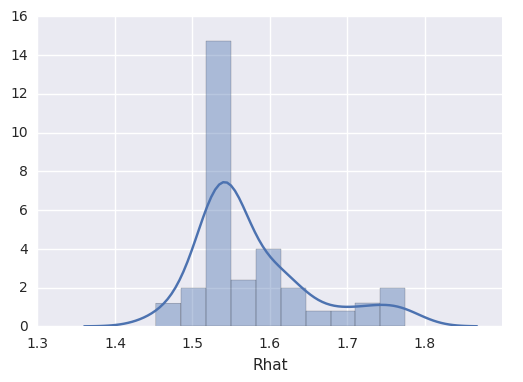

In [24]:
survivalstan.utils.plot_stan_summary([testfit], pars='log_baseline')

## summarize coefficient estimates

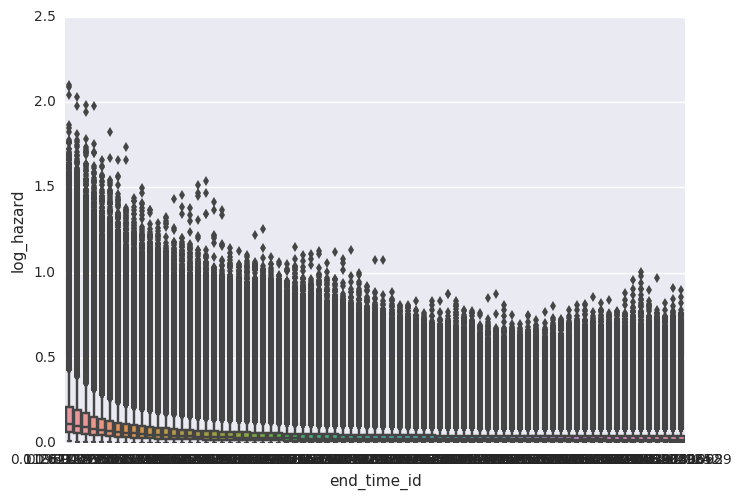

In [10]:
survivalstan.utils.plot_coefs([testfit], element='baseline')

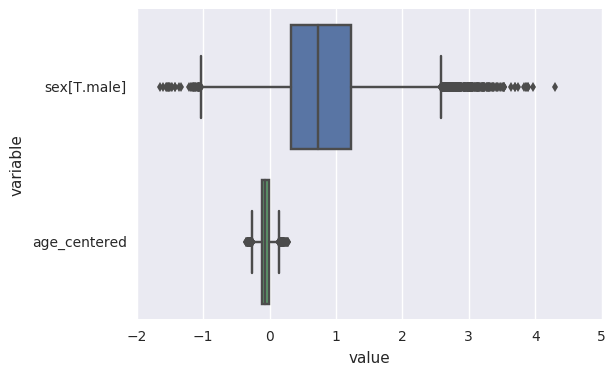

In [ ]:
survivalstan.utils.plot_coefs([testfit])

## posterior-predictive checks

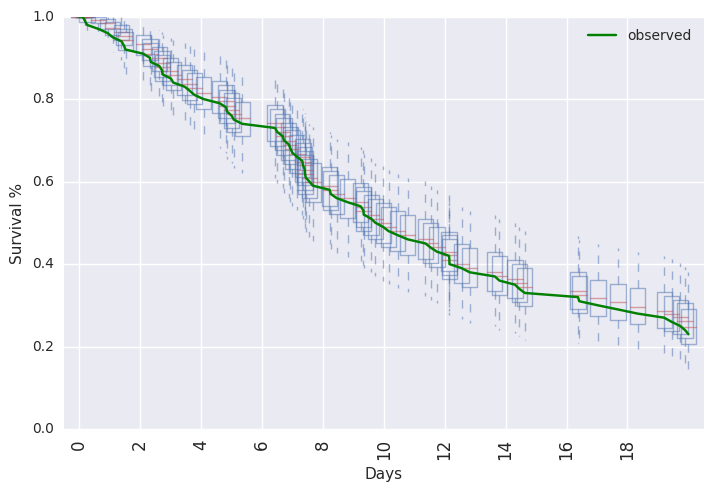

In [11]:
survivalstan.utils.plot_pp_survival([testfit], fill=False)
survivalstan.utils.plot_observed_survival(df=d, event_col='event', time_col='t', color='green', label='observed')
plt.legend()

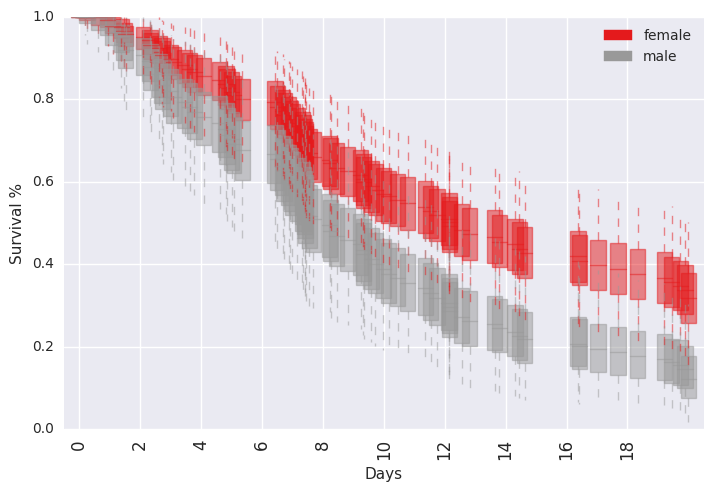

In [12]:
survivalstan.utils.plot_pp_survival([testfit], by='sex')

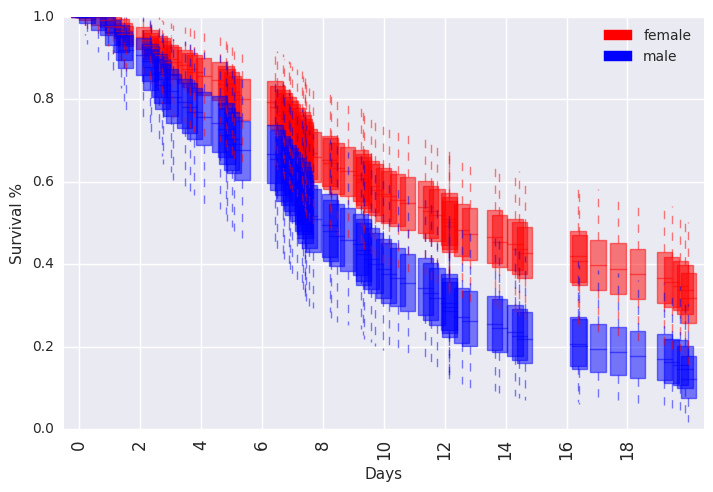

In [13]:
survivalstan.utils.plot_pp_survival([testfit], by='sex', pal=['red', 'blue'])

## summarize time-varying effect of sex on survival

In [ ]:
testfit['time_beta'] = survivalstan.utils.extract_time_betas(testfit)